In [2]:
import pandas as pd

cust_df = pd.read_csv("customers.csv")
cust_df.shape

(5000, 3)

In [3]:
cust_df.head()

,customer_id,age_cat,freq_cat
0,1,age20~34,freq2
1,2,age35~49,freq0
2,3,age35~49,freq0
3,4,age~19,freq0
4,5,age35~49,freq0


In [4]:
cust_df.dtypes

customer_id     int64
age_cat        object
freq_cat       object
dtype: object

<Axes: >

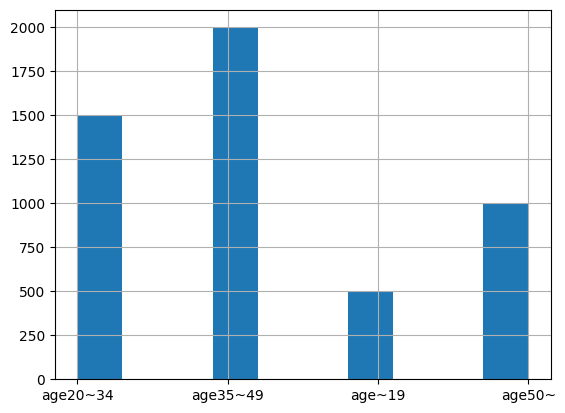

In [5]:
cust_df["age_cat"].hist()

<Axes: >

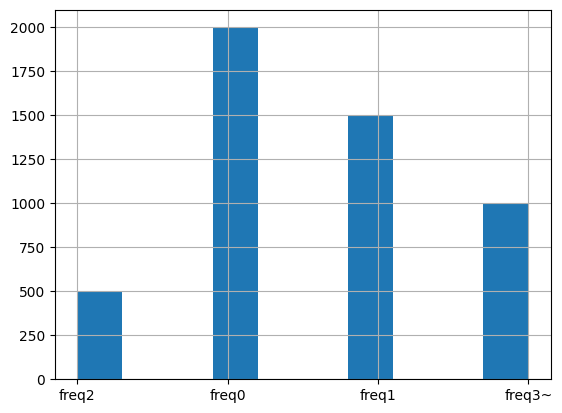

In [6]:
cust_df["freq_cat"].hist()

In [7]:
cust_pivot_df = pd.pivot_table(
    data=cust_df,
    values="customer_id",
    columns="freq_cat",
    index="age_cat",
    aggfunc="count",
)
cust_pivot_df = cust_pivot_df.reindex(["age~19", "age20~34", "age35~49", "age50~"])
cust_pivot_df

freq_cat,freq0,freq1,freq2,freq3~
age_cat,,,,
age~19,200,150,50,100
age20~34,600,450,150,300
age35~49,800,600,200,400
age50~,400,300,100,200


<Axes: xlabel='freq_cat', ylabel='age_cat'>

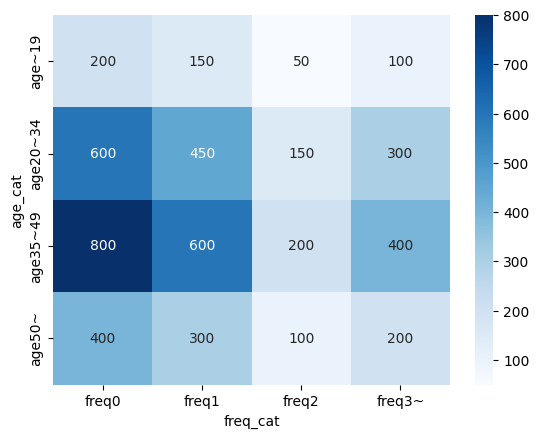

In [8]:
import seaborn as sns

sns.heatmap(cust_pivot_df, annot=True, fmt="d", cmap="Blues")

In [9]:
prob_df = pd.read_csv("visit_probability.csv")
prob_df.shape

(16, 6)

In [10]:
prob_df

,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,age~19,freq0,1,0.07,0.12,0.29
1,age~19,freq1,2,0.21,0.30,0.58
2,age~19,freq2,3,0.28,0.39,0.74
3,age~19,freq3~,4,0.35,0.45,0.77
4,age20~34,freq0,5,0.11,0.17,0.37
5,age20~34,freq1,6,0.32,0.43,0.72
6,age20~34,freq2,7,0.42,0.55,0.93
7,age20~34,freq3~,8,0.52,0.63,0.94
8,age35~49,freq0,9,0.08,0.14,0.33
9,age35~49,freq1,10,0.25,0.35,0.67


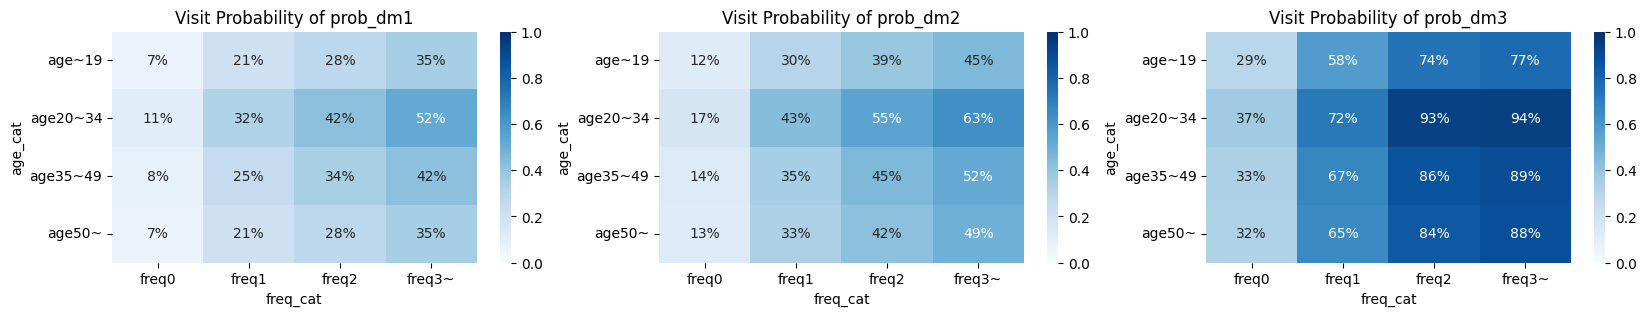

In [11]:
import matplotlib.pyplot as plt

ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1, 3, figsize=(20, 3))
for i, ptn in enumerate(["prob_dm1", "prob_dm2", "prob_dm3"]):
    prob_pivot_df = pd.pivot_table(
        data=prob_df, values=ptn, columns="freq_cat", index="age_cat"
    )
    prob_pivot_df = prob_pivot_df.reindex(["age~19", "age20~34", "age35~49", "age50~"])
    sns.heatmap(
        prob_pivot_df, vmin=0, vmax=1, annot=True, fmt=".0%", cmap="Blues", ax=ax[i]
    )
    ax[i].set_title(f"Visit Probability of {ptn}")
plt.show()

In [12]:
import pulp

problem = pulp.LpProblem(name="DiscountCouponProblem1", sense=pulp.LpMaximize)

In [13]:
I = cust_df["customer_id"].to_list()

In [14]:
M = [1, 2, 3]

In [15]:
xim = {}
for i in I:
    for m in M:
        xim[i, m] = pulp.LpVariable(name=f"xim({i},{m})", cat="Binary")
len(xim)

15000

In [16]:
for i in I:
    problem += pulp.lpSum(xim[i, m] for m in M) == 1

In [17]:
keys = ["age_cat", "freq_cat"]
cust_prob_df = pd.merge(cust_df, prob_df, on=keys)
cust_prob_df.head()

,customer_id,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,1,age20~34,freq2,7,0.42,0.55,0.93
1,2,age35~49,freq0,9,0.08,0.14,0.33
2,3,age35~49,freq0,9,0.08,0.14,0.33
3,4,age~19,freq0,1,0.07,0.12,0.29
4,5,age35~49,freq0,9,0.08,0.14,0.33


In [18]:
cust_prob_ver_df = cust_prob_df.rename(
    columns={"prob_dm1": 1, "prob_dm2": 2, "prob_dm3": 3}
).melt(id_vars=["customer_id"], value_vars=[1, 2, 3], var_name="dm", value_name="prob")
cust_prob_ver_df

,customer_id,dm,prob
0,1,1,0.42
1,2,1,0.08
2,3,1,0.08
3,4,1,0.07
4,5,1,0.08
...,...,...,...
14995,4996,3,0.32
14996,4997,3,0.32
14997,4998,3,0.67
14998,4999,3,0.65


In [19]:
Pim = cust_prob_ver_df.set_index(["customer_id", "dm"])["prob"].to_dict()

In [20]:
Pim[1, 1]

0.42

In [21]:
problem += pulp.lpSum((Pim[i, m] - Pim[i, 1]) * xim[i, m] for i in I for m in [2, 3])

In [22]:
Cm = {1: 0, 2: 1000, 3: 2000}

In [23]:
problem += (
    pulp.lpSum(Cm[m] * Pim[i, m] * xim[i, m] for i in I for m in [2, 3]) <= 1000000
)

In [24]:
S = prob_df["segment_id"].to_list()
len(S)

16

In [25]:
Ns = cust_prob_df.groupby("segment_id")["customer_id"].count().to_dict()
print(Ns)

{1: 200, 2: 150, 3: 50, 4: 100, 5: 600, 6: 450, 7: 150, 8: 300, 9: 800, 10: 600, 11: 200, 12: 400, 13: 400, 14: 300, 15: 100, 16: 200}


In [26]:
Si = cust_prob_df.set_index("customer_id")["segment_id"].to_dict()

In [ ]:
for s in S:
    for m in M:
        problem += pulp.lpSum(xim[i, m] for i in I if Si[i] == s) >= 0.1 * Ns[s]